In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn import preprocessing
#from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential
#from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score,mean_squared_error,max_error,mean_absolute_percentage_error
from sklearn import preprocessing
import plotly.graph_objects as go
#%matplotlib auto

import warnings
warnings.filterwarnings('ignore')

In [2]:
# def apply_windowing(X, y, idx, n_window):
#     dataX = X[idx:idx + WINDOW * n_window]  # prendo 5 valori alla volta

#     dataX = dataX.reshape((n_window, WINDOW, dataX.shape[1]))
#     dataY = y[idx:idx + WINDOW * n_window]
#     dataY = dataY.reshape((n_window, WINDOW, dataY.shape[1]))  # #rows/5, 5, #columns
#     print('Windowing applied')
#     return dataX, dataY

# def apply_inverse_windowing(X, y, n_window):
#     dataX = X.reshape((n_window * WINDOW, X.shape[2]))
#     dataY = y.reshape((n_window * WINDOW, y.shape[2]))
#     print('Inverse windowing applied')
#     return dataX, dataY

def add_dimension_1(x):
    if x.ndim == 1:
        return x.reshape((x.shape[0], 1))
    else:
        return x

def apply_scaler(train_X, train_y):
    
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(np.concatenate((train_X, train_y), axis=1))
    print('Scaler built')
    X_shape = train_X.shape
    y_shape = train_y.shape
    tmp = scaler.transform(np.concatenate((train_X, train_y), axis=1))    
    print('Scaler applied')
    return tmp[:, :X_shape[1]], tmp[:, X_shape[1]:]

def apply_inverse_scaler(train_Xo, train_yo, train_X, train_y):
    
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(np.concatenate((train_Xo, train_yo), axis=1))
    print('Scaler built')
    X_shape = train_X.shape
    y_shape = train_y.shape
    #tmp = scaler.transform(np.concatenate((train_X, train_y), axis=1))   
    tmp = scaler.inverse_transform(np.concatenate((train_X, train_y), axis=1)) 
    print('Scaler applied')
    return tmp[:, :X_shape[1]], tmp[:, X_shape[1]:]

In [3]:
def create_model(layer_lstm_sizes = 0, 
                 lstm_activation = 'tanh',
                 layer_dense_size = 3,
                 lstm_neurons = 32, 
                 dense_neurons = 32, 
                 penalty = 0.01, #0.00001,
                 huber_delta = 1,
                 undersampled = False, #True,
                 window_size = 1,
                 shuffle = True,
                 learning_rate=0.001,
                 rr=0.0001,
                 br=0.0001
                ):
    
    #model = tf.keras.Sequential()
    model = Sequential()
    # input layer
    model.add(LSTM(lstm_neurons, input_shape=input_shape, 
                kernel_regularizer= regularizers.l1_l2(penalty),
                recurrent_regularizer=keras.regularizers.l2(rr),
                bias_regularizer=keras.regularizers.l2(br),
                activation= lstm_activation,
                return_sequences=False #True
                     ))
#     # more hidden
#     for layer_number in range(layer_lstm_sizes):
#         model.add(LSTM(lstm_neurons, return_sequences=True, 
#                 kernel_regularizer= regularizers.l1_l2(penalty),
#                 activation= lstm_activation
#                      ))
#     # last hidden to stretch lstm over time
#     model.add(LSTM(lstm_neurons, return_sequences= False, 
#                 #kernel_regularizer= regularizers.l1_l2(penalty), #flattens too much the curve?
#                 activation= lstm_activation
#                      ))
    for layer in range(layer_dense_size):
        model.add(Dense(dense_neurons, 
                               #kernel_regularizer= regularizers.l1_l2(penalty), #flattens too much the curve?
                               activation='relu'))
        
    model.add(Dense(output_shape))
    
    opt = keras.optimizers.Adam(learning_rate=learning_rate) # default 0.001
    #loss = 'mean_squared_error' #keras.losses.Huber(delta=huber_delta)
    loss = keras.losses.Huber(delta=huber_delta)
    model.compile(loss=loss, optimizer=opt,
             metrics=[tf.keras.metrics.MeanSquaredError()] # necessary, if we add regularization it will be included in loss
             ) 
    return model

In [4]:
def apply_model_predict(model, X, y):  # re-align y_predict shape to y shape
    predict_y = model.predict(X)
    print('Model has been applied to predict signal')
    #predict_y = predict_y.reshape(y.shape)
    return predict_y

def metric(reco, true):
    import numpy as np
    #print('len true: ', len(true))
    #print('len reco: ', len(reco))
    thr= 0.78 * np.percentile(np.array(true),95)
    rel_diff = np.array([abs(np.array(t)-np.array(r))/t for t,r in zip(true, reco) if t>thr])
    mymin = np.percentile(rel_diff,1)
    mymax = np.percentile(rel_diff,99)
    out = [x for x in rel_diff if (x > mymin and x < mymax)]
    d = np.average(out)*100
    diff = np.array([abs(np.array(t)-np.array(r)) for t,r in zip(true, reco) if t>thr])
    p50 = np.percentile(diff, 50)
    p90 = np.percentile(diff, 90)
    #print(p90)
    
    # voglio trovare x tc np.percentile(diff, x)=20°C
    min_perc = 0.
    max_perc = 100.01
    step = 0.01
    y = np.arange(min_perc, max_perc, step)
    perc = [np.percentile(diff, _x) for _x in y]
    smaller_20 = perc < 20*np.ones(len(y))
    x_20 = y[np.argmin(smaller_20)]
    smaller_10 = perc < 10*np.ones(len(y))
    x_10 = y[np.argmin(smaller_10)]
    
    # want to understand which is the average/median discrepancy of the latest 10% of the distribution
    sorted_diff = np.sort(diff) # dal più piccolo al più grande
    latest_x_10 = sorted_diff[int(x_10/100*len(diff)):] # ultimo x% dei dati
    mean_over = np.mean(latest_x_10)
    median_over = np.median(latest_x_10)
    #print('metric function executed once')
    print('largest value in the distribution: ', diff.max())
    return round(d,1), round(p50,1), round(p90,1), round(x_10,2), round(mean_over, 1), round(median_over, 1)

In [5]:
lstm_neurons=32
dense_neurons = 32
penalty=0 #0.01
layer_lstm_sizes=0
layer_dense_size=3
lstm_activation='relu' #'tanh'
learning_rate=0.0005
epochs=5000
rr=0 #0.0001
br=0 #0.0001

MyListVec = [] #list()

MyList=[layer_lstm_sizes,lstm_activation,layer_dense_size,lstm_neurons,32,penalty,1,True,1,True,learning_rate,epochs,rr,br]
MyListVec.append(list(MyList))

# # MyList=[1,2,1]
# # MyListVec.append(list(MyList))
# # print(MyListVec)

# for lstm_neurons in [16,32,64,128]:
#     for penalty in [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]: 
#         for layer_lstm_sizes in[1,2,3,4]:
#             for layer_dense_size in[0,1,2,4,5]: 
#                 for lstm_activation in ['relu']:

#                     MyList=[layer_lstm_sizes,lstm_activation,layer_dense_size,lstm_neurons,32,penalty,1,True,1,True]
#                     MyListVec.append(list(MyList))

# for learning_rate in [0.0001, 0.001, 0.01]:
#     MyList=[layer_lstm_sizes,lstm_activation,layer_dense_size,lstm_neurons,32,penalty,1,True,1,True,learning_rate]
#     MyListVec.append(list(MyList))  

# MyListVec = [] #list()
# for epochs in [500]: #, 600, 700, 800, 900, 1000]:
#     for penalty in [0.0001, 0.001, 0.01]: #,0.01,0.005,0.001,0.0005,0.0001]: 
#         for rr in [0.0001, 0.001, 0.01]: 
#             for br in [0.0001, 0.001, 0.01]:  
#                 MyList=[layer_lstm_sizes,lstm_activation,layer_dense_size,lstm_neurons,dense_neurons,penalty,1,True,1,True,learning_rate,epochs,rr,br]
#                 MyListVec.append(list(MyList)) 

[0, 'relu', 3, 32, 32, 0, 1, True, 1, True, 0.0005, 5000, 0, 0]
(56234, 14)
['Tin _K_', 'Pin _kPa_', 'N _rpm_', 'Total Consumed power', 'Qin _m3/s_', 'Pout _kPA_', 'GVFin', 'Hp _kJ/kg_', 'GVFout', 'Qv_out _m3/s_', 'Surge Distance', 'phi', 'Diff_Pressure', 'Surge Distance Eq']
Scaler built
Scaler applied
37489


mkdir: cannot create directory ‘test1’: File exists


2022-04-12 13:21:23.348118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30170 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0
2022-04-12 13:21:24.259869: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4864      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 8,065
Trainable params: 8,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
1/1 [==============================] - 3s 3s/step - loss: 0.5603 - mean_squared_error: 0.9933
Epoch 2/5000


mv: cannot move 'test1' to '0_relu_3_32_32_0_1_True_1_True_0.0005_5000_0_0/test1': Directory not empty


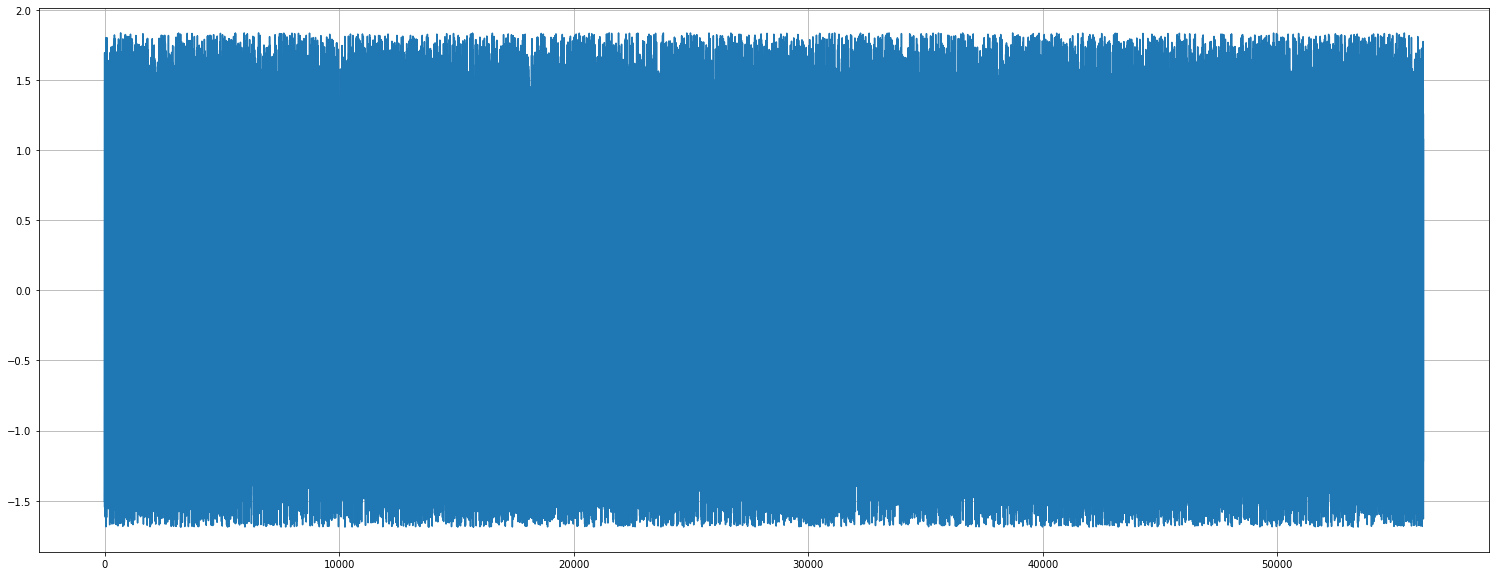

In [6]:
for MyList in MyListVec:
    print(MyList)
    os.system('mkdir test1')
    
    # #data_file = '../PEM1_clean.csv'
    # data_file = '../PEM_Clean2.csv'
    # #data_file = 'PEM2_Clean2.csv'
    # df = pd.read_csv(data_file, sep=',')
    df=pd.read_pickle('DataL2_Full.pkl')

    #df = pd.read_pickle('../Local/L360.pkl')
    #df=df[df['BRNDMD']>39]
    #df = df.reset_index()
    train_model=1

    df=df[['Tin [K]','Pin [kPa]','N [rpm]','Total Consumed power',
           'Qin [m3/s]', 'Pout [kPA]', 'GVFin', 'Hp [kJ/kg]', 'GVFout','Qv_out [m3/s]','Surge Distance', 'phi']]
    df['Diff_Pressure'] = df['Pout [kPA]'] - df['Pin [kPa]']
    phi_surge=0.076
    df['Surge Distance Eq'] = 100*(df['phi']-phi_surge)/phi_surge 
    df=df[df['Surge Distance Eq']>0]
    
    import re
    # since this xgb version does not recognise column names with square brackets, commas,\ they need to be replaced with _ 
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    # since this xgb version does not recognise column names with square brackets, commas need to replace the column names.
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
    
    print(df.shape)

    ldf=len(df)

    all_tags=list(df.columns)
    print(all_tags)
    
    x_tags=['Tin _K_','Pin _kPa_','N _rpm_','Diff_Pressure','Total Consumed power']
    y_tag ='Surge Distance Eq' #['GVFin','Qin _m3/s_'] #,'Hp _kJ/kg_','GVFout','Qv_out _m3/s_','phi','Surge Distance']

    
    X = df[x_tags].values
    y = df[y_tag].values

    X = add_dimension_1(X)
    y = add_dimension_1(y)

    Xo=X;yo=y
    X, y = apply_scaler(X, y)

    X=np.expand_dims(X,axis = 1)
    #y=np.expand_dims(y,axis = y.ndim)

    #plt.plot(X)
    plt.figure(1,figsize=(26,10))
    plt.plot(y)
    plt.grid(True)

    ns=int(ldf*2/3) 
    X_train=X[:ns][:];X_test=X[ns:-1][:];
    y_train=y[:ns];y_test=y[ns:-1];

#     il faudrait train, val, test
#     ns1=int(ldf*1/2) ;ns2=int(ldf*3/4)
#     X_train=X[:ns1][:];X_test=X[ns1:ns2][:];
#     y_train=y[:ns1];y_test=y[ns1:ns2];    


    idx=0
    #train_X, train_y = apply_windowing(X, y, idx, n_window)
    #display(train_y)

    train_X = X_train
    train_y = y_train
    test_X = X_test
    test_y = y_test


    input_shape = (train_X.shape[1], train_X.shape[2])
    output_shape = train_y.shape[1] 
    
    batch_size = int(float(train_X.shape[0])); print(batch_size)    

    
    #MyList=[layer_lstm_sizes,lstm_activation,layer_dense_size,lstm_neurons,32,penalty,1,True,1,True]
    #print(MyList)
    
    with open('MyList.txt', 'w') as f:
        f.write(str(MyList))

    model = create_model(layer_lstm_sizes = MyList[0], # in any case, 2 layers are present
                     lstm_activation = MyList[1], #'tanh',
                     layer_dense_size = MyList[2],  # actually x dense layer before output layer
                     lstm_neurons = MyList[3], 
                     dense_neurons = MyList[4], 
                     penalty = MyList[5],
                     huber_delta = MyList[6],
                     undersampled = MyList[7], # for csv tracking
                     window_size = MyList[8], #5, # for csv tracking
                     shuffle = MyList[9],
                     learning_rate=MyList[10],
                     rr=MyList[12],
                     br=MyList[13]) # try also without

    model.summary()
    
    start = time.time()

    history = model.fit(train_X, train_y, 
                        shuffle=True, 
                        epochs=MyList[11], batch_size=batch_size, #128,
                        verbose=1)

    stop = time.time()
    delta_time = stop-start

    print('Model has been fit in ', delta_time, 'seconds')
    
    
    # Saving Model to json files #
    # -------------------------- #
    import json

    json_filename= 'test1/MyModel.json'
    weights_filename = 'test1/MyWeights.h5'

    model_json = model.to_json()   # questo permette il recupero del modello passando da GPU a CPU  --> sostituirlo in training
    with open(json_filename, 'w') as json_file:
        json.dump(model_json, json_file)

    model.save_weights(weights_filename)  # questo permette il recupero del modello passando da GPU a CPU --> sostituirlo in training

    print('Model json and weights have been saved')
    #---
    
    train_X.shape, train_y.shape
    old_model=model

    predict_y = apply_model_predict(old_model, train_X, train_y)
    predict_y_test = apply_model_predict(old_model, test_X, test_y)

    predict_y_full = apply_model_predict(old_model, X, y)

    X = X[:,0,:]
    X, predict_y_full = apply_inverse_scaler(Xo, yo, X, predict_y_full)

    ns=int(ldf*2/3) 
    predict_y_train2=predict_y_full[:ns];predict_y_test2=predict_y_full[ns:-1];
    y_train2=yo[:ns];y_test2=yo[ns:-1];

    # Evaluation de la qualité du fit
    from sklearn import metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # print('RMSE train: %.3f, test: %.3f' % (np.sqrt(metrics.mean_squared_error(y_train2, predict_y_train2)),
    #                                         np.sqrt(metrics.mean_squared_error(y_test2, predict_y_test2))))

    train_rmse = np.sqrt(metrics.mean_squared_error(y_train2, predict_y_train2)) 
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test2, predict_y_test2))

    print('RMSE train: %.3f, test: %.3f' % (train_rmse,test_rmse))

    train_rmedse = np.sqrt(np.median((np.square(y_train2 - predict_y_train2)))) #.median(axis=0))
    test_rmedse = np.sqrt(np.median((np.square(y_test2 - predict_y_test2)))) #.median(axis=0))

    print('RMedSE train: %.3f, test: %.3f' % (train_rmedse,test_rmedse))

    print('MAE train: %.3f, test: %.3f' % (mean_absolute_error(y_train2, predict_y_train2),
                                            mean_absolute_error(y_test2, predict_y_test2)))

    with open('test1/MyScore1.txt', 'w') as f:
        f.write('RMSE train: %.3f, test: %.3f' % (train_rmse,test_rmse))
        f.write('\n')
        f.write('RMedSE train: %.3f, test: %.3f' % (train_rmedse,test_rmedse))
        f.write('\n')
        f.write('MAE train: %.3f, test: %.3f' % (mean_absolute_error(y_train2, predict_y_train2),
                                            mean_absolute_error(y_test2, predict_y_test2)))

    with open('test1/MyScore0.txt', 'w') as f:
        f.write('%.3f\t%.3f\t%.3f' % (test_rmse,test_rmedse,mean_absolute_error(y_test2, predict_y_test2)))   

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df.index,y=yo[:,0],name=y_tag,mode="lines"))
    fig.add_trace(go.Scatter(y=predict_y_full[:,0],name='predict_y',mode="lines"))
    #fig.add_trace(go.Scatter(x=df.index[7001:],y=predict_y_test[:,0],name='predict_y_test',mode="lines"))

    fig.update_layout(title="Double click on 1 legend to hide or show all the curves, Zoom only x axis by going only left or right")
    fig.write_html('test1/df_y_pred.html', auto_open=False)
    #fig.show()

    #my_ss_metric = metric(ss_pred_y, ss_y)
    my_ss_metric = metric(predict_y, y)

    print('Metric over steady state points (avg discrepancy, p50, p90, px=10): ', my_ss_metric[:4]) #comparer à 0.017

    my_ss_metric

    with open('test1/MyScore2.txt', 'w') as f:
        #f.write('\n')
        f.write(str(my_ss_metric))

    #MyDir=str(MyList[0])+'_'+str(MyList[1])+'_'+str(MyList[2])+'_'+str(MyList[3])+'_'+str(MyList[4])+'_'+str(MyList[5])+'_'+str(MyList[6])+'_'+str(MyList[7])+'_'+str(MyList[8])+'_'+str(MyList[9])+'_'+str(MyList[10])

    #Creating the directory name with all the parameters
    MyDir=''
    for i in range(len(MyList)):
        MyDir=MyDir+str(MyList[i])+'_'
    MyDir=MyDir[:-1] #removing the last _

    os.system('mv test1 '+MyDir)

(0.0, 100.0)

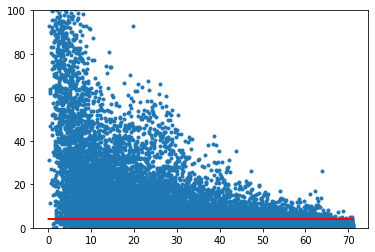

In [7]:
out='Surge Distance Eq'
plt.plot(y_test2,abs(y_test2-predict_y_test2)/y_test2*100,'.')
plt.plot(y_test2,4*np.ones(len(y_test2)),'r')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
plt.ylim(0,100)

In [8]:
data = df.copy()
data = data.iloc[ns:-1,:]

In [9]:
data['Surge Distance Eq_pred'] = predict_y_test2

In [10]:
import math
output_c2=['Surge Distance Eq']
for i, out in enumerate(output_c2):
    print(f'RMSE_test set_{out}', math.sqrt(mean_squared_error(data[out],data[out+'_pred'])))
    print(f'R2 Score_test set_xgb_{out}', r2_score(data[out],data[out+'_pred']))
#     print('________________________________\n')

RMSE_test set_Surge Distance Eq 2.862514376751065
R2 Score_test set_xgb_Surge Distance Eq 0.9797889373438433


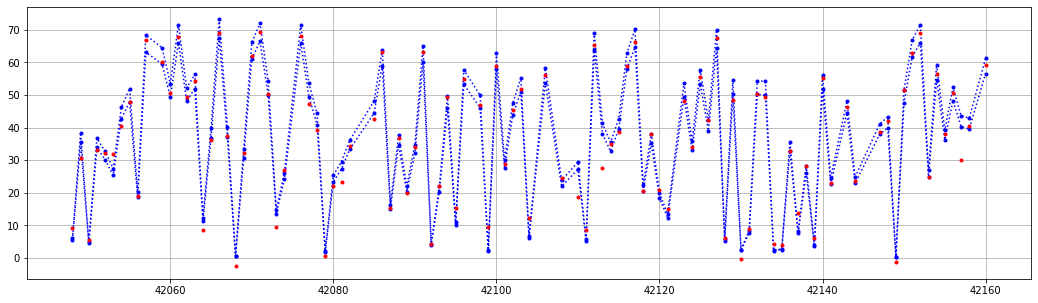

In [11]:
out='Surge Distance Eq'
fig = plt.figure(figsize=(18,5))
plt.plot(data.head(100)[out]*1.04,'b.:')
plt.plot(data.head(100)[out]*0.96,'b.:')
plt.plot(data.head(100)[out+'_pred'],'r.')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
#plt.ylim(0,50)
plt.grid(True)

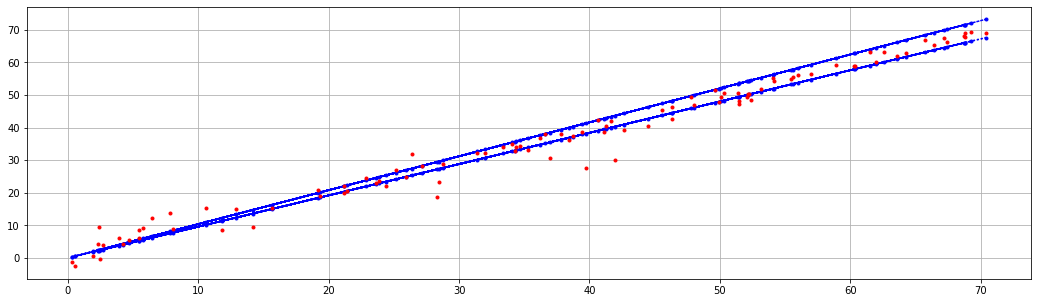

In [12]:
out='Surge Distance Eq'
fig = plt.figure(figsize=(18,5))
plt.plot(data.head(100)[out],data.head(100)[out]*1.04,'b.:')
plt.plot(data.head(100)[out],data.head(100)[out]*0.96,'b.:')
plt.plot(data.head(100)[out],data.head(100)[out+'_pred'],'r.')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
#plt.ylim(0,50)
plt.grid(True)

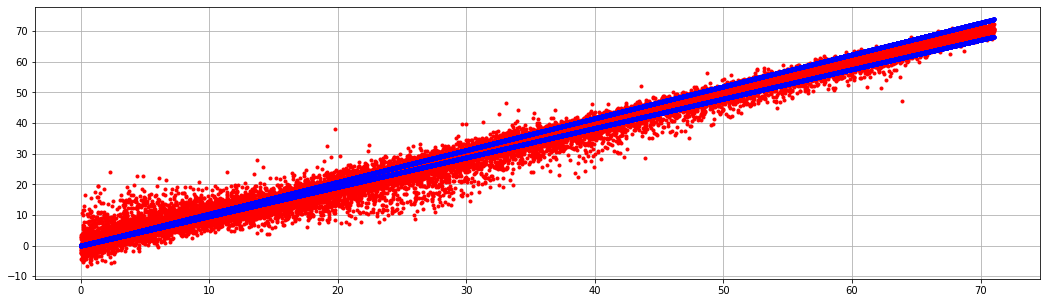

In [13]:
out='Surge Distance Eq'
fig = plt.figure(figsize=(18,5))
plt.plot(data[out],data[out+'_pred'],'r.')
plt.plot(data[out],data[out]*1.04,'b.:')
plt.plot(data[out],data[out]*0.96,'b.:')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
#plt.ylim(0,50)
plt.grid(True)

In [14]:
out='Surge Distance Eq'
data['ErrSDpc']=abs(data[out]-data[out+'_pred'])/data[out]*100

In [15]:
ds=data['ErrSDpc'][data['ErrSDpc']<4]

In [16]:
ds

42052    2.704523
42056    1.536371
42057    1.611501
42059    2.767211
42060    1.450532
           ...   
63106    1.583226
63107    3.312604
63108    2.105414
63109    3.378796
63114    1.789863
Name: ErrSDpc, Length: 9251, dtype: float64

In [17]:
len(ds)

9251

In [18]:
len(data)

18744

In [19]:
len(ds)/len(data)

0.4935446009389671

<AxesSubplot:>

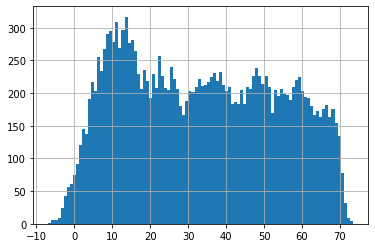

In [20]:
data['Surge Distance Eq_pred'].hist(bins=100)

<AxesSubplot:>

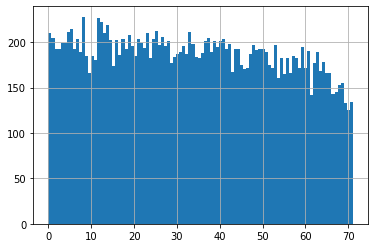

In [21]:
data['Surge Distance Eq'].hist(bins=100)

In [22]:
data['Surge Distance Eq_residuals']=data[out]-data[out+'_pred']


In [23]:
# Get mean as standard deviation
mean = data['Surge Distance Eq_residuals'].mean()
std = data['Surge Distance Eq_residuals'].std()

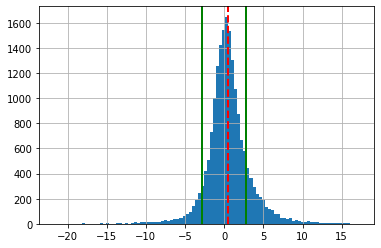

In [24]:
data['Surge Distance Eq_residuals'].hist(bins=100)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(std, color='g', linewidth=2)
plt.axvline(-std, color='g', linewidth=2)

In [25]:
std

2.8163786149728383

<AxesSubplot:>

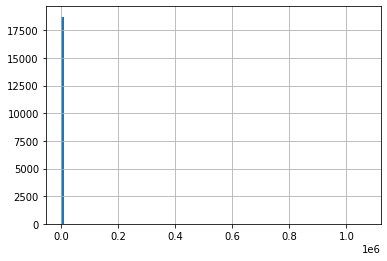

In [26]:
data['ErrSDpc'].hist(bins=100)

<AxesSubplot:>

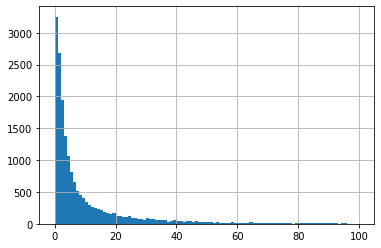

In [27]:
data['ErrSDpc'].hist(bins=100,range=[0,100])

<AxesSubplot:>

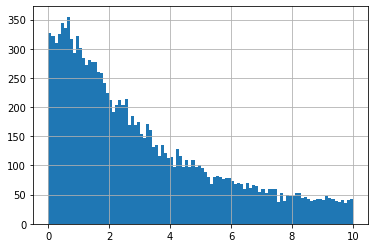

In [28]:
data['ErrSDpc'].hist(bins=100,range=[0,10])

In [29]:
data['ErrSDpc'].max()

1066566.665647877

In [30]:
A=data['ErrSDpc'].sort_values()

In [31]:
A=A.reset_index()

In [32]:
A

,index,ErrSDpc
0,49041,5.297621e-05
1,58703,5.679808e-04
2,57874,7.727514e-04
3,59073,1.676180e-03
4,55012,2.728371e-03
...,...,...
18739,44320,1.378388e+04
18740,44865,1.707164e+04
18741,42996,1.897365e+04
18742,47112,4.216944e+04


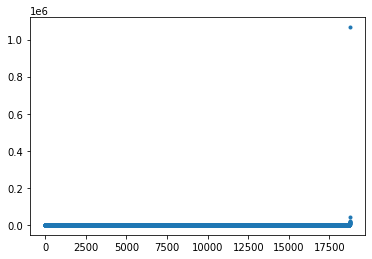

In [33]:
plt.plot(A.index,A['ErrSDpc'],'.')

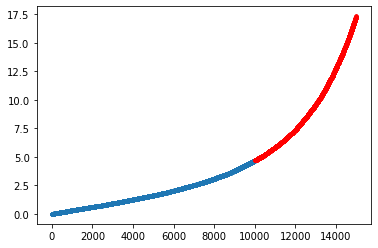

In [34]:
A1=A[0:10000]
A2=A[10001:15000]
plt.plot(A1.index,A1['ErrSDpc'],'.')
plt.plot(A2.index,A2['ErrSDpc'],'r.')